# Uzun Kısa Süreli Bellek (Long Short Term Memory)(LS)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.datasets import fetch_20newsgroups # 20 farklı kategoride haber metinlerini getirir.
from sklearn.preprocessing import LabelEncoder # Etiketleri sayısal formata çevirir .
from sklearn.model_selection import train_test_split # Veriyi eğitim ve test olarak parçalar .

from tensorflow.keras.preprocessing.text import Tokenizer # Metin verisini sayıya çevirir .
from tensorflow.keras.preprocessing.sequence import pad_sequences # Dizileri aynı uzunluğa getirir .
from tensorflow.keras.models import Sequential # Keras'ta model oluşturma sınıfı.
from tensorflow.keras.layers import Embedding , LSTM , Dense , Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

### 1)Veri Setinin Yüklenmesi 

In [2]:
newsgroup = fetch_20newsgroups(subset="all") # Tüm verilerin yüklenmesi işlemi .

### 2)Veri Ön İşleme

In [3]:
X = newsgroup.data # Metinler 
Y = newsgroup.target # Metinlere karşılık gelen etiketler

Metin verisini tokenize etme ve padding işlemleri 

In [4]:
tokenizer = Tokenizer(num_words=10000) # num_words : En çok kullanılan kelime sayısı.
tokenizer.fit_on_texts(X) # Tokenizer i metin verisi ile fit edelim
X_sequences = tokenizer.texts_to_sequences(X) # Metinleri sayısala çevirme işlemi
X_padded = pad_sequences(X_sequences,maxlen=100) # Metinleri aynı uzunluğa getirme işlemi.

Etiketleri sayısal hale dönüştürme . (Label Encoding)

In [5]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)

Verileri Train/Test olarak ayrılması işlemi 

In [6]:
x_train , x_test , y_train , y_test = train_test_split( X_padded , y_encoded,test_size = 0.2 , random_state = 42 )

In [7]:
from tensorflow.keras import backend as B 
#Bir model değerlendirme işlemi olan f1_score fonk. yazılması işlemi
def f1_score(y_true,y_preds):
    y_pred = B.round(y_preds)
    print(y_true,y_preds)
    tp = B.sum(B.cast(y_true * y_preds , "float"),axis=0)
    fp = B.sum(B.cast((1 - y_true)*y_preds,"float"),axis=0)
    fn = B.sum(B.cast(y_true*(1 - y_preds),"float"),axis=0)

    precision = tp / ( tp + fp + B.epsilon() )
    recall = tp / (tp + fn + B.epsilon() )
    f1 = 2 * (precision * recall) / (precision + recall + B.epsilon())
    result = B.mean(f1)

    return result

### 3) Eğitim Modelinin Oluşturulması 
(LSTM Model)

In [8]:
# Katmanlar => Embedding + LSTM + Dropout + Output

def build_lstm_model():
    model = Sequential()

    #Embedding Katmanı
    #input_dim : Kelime Vektörlerinin toplam boyutu
    #output_dim : Kelime vektürlerinin boyutu
    #input_length : Her Giriş Metninin Boyutu
    model.add(Embedding(input_dim = 10000 , output_dim = 64 , input_length = 100 ))

    #LSTM Katmanı
    #return_sequence : Sonuçları tüm zaman adımı yerine son adımda return edilmesi .
    model.add(LSTM(units = 64 , return_sequences = False ))
    
    #Dropout
    model.add(Dropout(0.5))

    #Dense Katmanı (OUTPUT)
    model.add(Dense(20,activation = "softmax"))

    #Model Compile
    model.compile(optimizer = "adam" , loss = "sparse_categorical_crossentropy" , metrics = ["accuracy"])

    return model


In [9]:
models = build_lstm_model()
models.build(input_shape=(None, 100))

In [10]:
models.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 674,324 (2.57 MB)

 Trainable params: 674,324 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

### 4)Modelin Eğitimi

Callbacks (Early Stopping)

In [11]:
early_stopping = EarlyStopping(monitor = "val_accuracy",patience = 5 , restore_best_weights = True)

In [12]:
history = models.fit(x_train , y_train , epochs = 20 , batch_size = 32 , validation_split = 0.1 ,callbacks = [early_stopping])

Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1078 - loss: 2.8540 - val_accuracy: 0.2924 - val_loss: 2.1484
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3269 - loss: 1.9858 - val_accuracy: 0.3932 - val_loss: 1.8492
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.4714 - loss: 1.5460 - val_accuracy: 0.4881 - val_loss: 1.6326
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5705 - loss: 1.2645 - val_accuracy: 0.5776 - val_loss: 1.3155
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6802 - loss: 1.0181 - val_accuracy: 0.6034 - val_loss: 1.2578
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7735 - loss: 0.7457 - val_accuracy: 0.6505 - val_loss: 1.1796
Epoch 7/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8333 - loss: 0.5712 - val_accuracy: 0.6837 - val_loss: 1.1627
Epoch 8/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8694 - loss: 0.4539 - val_acc

### 5)Model Değerlendirilmesi

In [13]:
loss , accuracy = models.evaluate(x_test,y_test)
print(f"Test Loss : {loss:.4f} Test Accuracy : {accuracy:.4f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7105 - loss: 1.2203
Test Loss : 1.1826 Test Accuracy : 0.7218


Sonuçların görselleştirilmesi

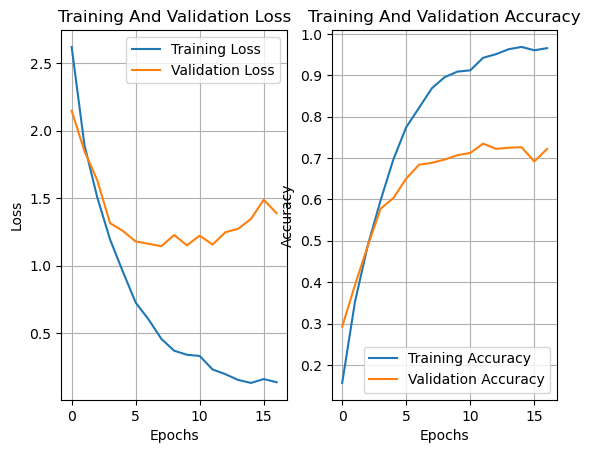

In [14]:
plt.figure()

plt.subplot(1,2,1)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.title("Training And Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid("True")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"],label="Training Accuracy")
plt.plot(history.history["val_accuracy"],label="Validation Accuracy")
plt.title("Training And Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid("True")